# The Pulsar Monitor analyzer is intended to make the public GBM pulsar files easily accessible for analysis.
# This code defines a pulsar object which is initialized with a pathname to the pulsar fits file publically available at: https://gammaray.msfc.nasa.gov/gbm/science/pulsars.html

# Basic Instructions:
# 1) Download the fits file for the pulsar of interest. 
# 2) Run this notebook.
# 3) Make an instance of the Pulsar class: pulsar = Pulsar(pathname).  Example: oao1657 = Pulsar('oao1657.fits').  The file name should include the path to the downloaded fits file.
# 4) The data in the fits file is available through the class variables located in the __init__ method.  
# 5) Plotting the frequency and pulsed flux is accomplished with the Pulsar.plot() method: oao1657.plot().
# 6) Pulsar information is available with the Pulsar.printinfo() method: oao1657.printinfo().
# 7) All Plotting ranges are adjustable with keywords in the Pulsar.plot() call: tmin,tmax,fmin,fmax,amin,amax, where t is time, f is frequency, a is pulsed flux amplitude.  
# 8) The 'Y' range will always be automatically set with the current tmin, tmax unless you specify the range in the call to .plot().
# 9) The 'X' range can be independently set by changing the Pulsar.tmin or Pulsar.tmax or using the keyword tmin and tmax in the Pulsar.plot() call.  The 'Y' range can only be independently changed with keywords in the Pulsar.plot() call.
# 10) All times are in MJD.

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
#
class Pulsar:
# initialize class
    def __init__(self, filename):
        hdulist = fits.open(filename)
        orb_elem = hdulist[1].data
        self.name = orb_elem.field("NAME")[0]
        self.ra = orb_elem.field("RA")[0]
        self.dec = orb_elem.field("DEC")[0]
        self.binary = orb_elem.field("BINARY")
        self.pbinary = orb_elem.field("PBINARY")[0]
        self.pbdot = orb_elem.field("PBDOT")[0]
        self.epoch_type = orb_elem.field("EPOCH_TYPE")[0]
        self.binaryepoch = orb_elem.field("BINARYEPOCH")[0]
        self.axsini = orb_elem.field("AXSINI")[0]
        self.periapse = orb_elem.field("PERIAPSE")[0]
        self.apsidalrate = orb_elem.field("APSIDALRATE")[0]
        self.eccentricity = orb_elem.field("ECCENTRICITY")[0]
        self.egress = orb_elem.field("EGRESS")[0]
        self.ingress = orb_elem.field("INGRESS")[0]
        hist = hdulist[2].data
        self.tstart = hist.field("TSTART")[hist.field("DETECTED") == 1]
        self.tstop = hist.field("TSTOP")[hist.field("DETECTED") == 1]
        self.psrtime = hist.field("PSRTIME")[hist.field("DETECTED") == 1]
        self.frequency = hist.field("FREQUENCY")[hist.field("DETECTED") == 1]
        self.frequency_err = hist.field("FREQUENCY_ERR")[hist.field("DETECTED") == 1]
        self.amplitude = hist.field("AMPLITUDE")[hist.field("DETECTED") == 1]
        self.amplitude_err = hist.field("AMPLITUDE_ERR")[hist.field("DETECTED") == 1]
        self.numharm = hist.field("NUMHARM")[hist.field("DETECTED") == 1]
        hdulist.close()
        # tmin and tmax set the plotting bounds in MJD
        self.tmin = np.ndarray.min(self.psrtime) - 20.
        self.tmax = np.ndarray.max(self.psrtime) + 20.
        self.fmin = (np.ndarray.min(self.frequency) - np.ndarray.max(self.frequency_err)) * 1000.0
        self.fmax = (np.ndarray.max(self.frequency) + np.ndarray.max(self.frequency_err)) * 1000.0
        self.amin = np.ndarray.min(self.amplitude) - np.ndarray.max(self.amplitude_err)
        self.amax = np.ndarray.max(self.amplitude) + np.ndarray.max(self.amplitude_err)
    def printinfo(self):
        if self.binary == 'Y' :
            print('Source name {} ra={} dec={}'.format(self.name, self.ra, self.dec))
            print('The following ephemeris is used to determine pulsar emission frequencies')
            print('Binary orbital period is {} days'.format(self.pbinary))
            if np.abs(self.pbdot) > 0:
                print('Binary orbital period derivative is {} days/day'.format(self.pbdot))
            if self.epoch_type =='T':
                print('Pi/2 Epoch is {} JED'.format(self.binaryepoch))
            else:
                print('Periastron Epoch is {} JED'.format(self.binaryepoch))
            print('AXSIN(i) is {} light-sec'.format(self.axsini) )
            print('Long. of periastron is {} deg'.format(self.periapse))
            print('Eccentricity is {}'.format(self.eccentricity))
            if self.egress > 0:
                print('Source is eclipsing:')
                print('Egress is {}'.format(self.egress))
                print('Ingress is {}'.format(self.ingress))
        else:
            print('Source name {} ra={} dec={}'.format(self.name, self.ra, self.dec))
            print('No ephemeris is used and frequencies are not corrected for the pulsar orbit')
    def setminmax(self,fmin=None,fmax=None,amin=None,amax=None):
        # Use user defined vertical plot ranges.  Automatically set using current tmin and tmax 
        # if vertical plot ranges are unspecified
        if fmin is None:
            self.fmin = (np.ndarray.min(self.frequency[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])- \
                np.ndarray.max(self.frequency_err[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])) * 1000.0
        else:
            self.fmin = fmin
        if fmax is None:
            self.fmax = (np.ndarray.max(self.frequency[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])+\
                np.ndarray.max(self.frequency_err[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])) * 1000.0
        else:
            self.fmax = fmax
        if amin is None:
            self.amin = np.ndarray.min(self.amplitude[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])- \
                np.ndarray.max(self.amplitude_err[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])
        else:
            self.amin = amin
        if amax is None:
            self.amax = np.ndarray.max(self.amplitude[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])+\
                np.ndarray.max(self.amplitude_err[(self.psrtime >= self.tmin) * (self.psrtime < self.tmax)])
        else:
            self.amax = amax
    def plot(self,tmin=None,tmax=None,fmin=None,fmax=None,amin=None,amax=None):
        #Use user supplied tmin tmax [MJD]
        if tmin is not None:
            self.tmin = tmin
        if tmax is not None:
            self.tmax = tmax
        self.setminmax(fmin = fmin, fmax = fmax, amin = amin, amax = amax)
        plt.figure(1)
        plt.subplot(211)        
        plt.ylabel('Frequency [mHz]')
        plt.axis([self.tmin,self.tmax,self.fmin,self.fmax])
        plt.errorbar(self.psrtime, self.frequency*1000.,self.frequency_err*1000.,fmt='.')
        plt.subplot(212)
        plt.axis([self.tmin,self.tmax,self.amin,self.amax])
        plt.xlabel('Time [MJD]')
        plt.ylabel('12-25 keV Pulsed Flux')
        plt.errorbar(self.psrtime, self.amplitude,self.amplitude_err,fmt='.')
        plt.show()


## Make an instance of the Pulsar class: pulsar = Pulsar(pathname).  The file name should include the path to the downloaded fits file.

In [3]:
oao1657 = Pulsar('oao1657.fits')

## Plotting the frequency and pulsed flux is accomplished with the Pulsar.plot() method: 

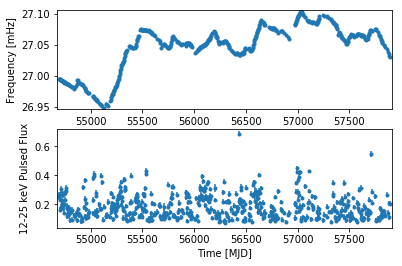

In [4]:
oao1657.plot()

## Pulsar information is available with the Pulsar.printinfo() method: 

In [5]:
oao1657.printinfo()

Source name OAO 1657-415 ra=255.20375 dec=-41.656
The following ephemeris is used to determine pulsar emission frequencies
Binary orbital period is 10.4472921 days
Binary orbital period derivative is -9.74e-08 days/day
Pi/2 Epoch is 2452298.5179 JED
AXSIN(i) is 106.157 light-sec
Long. of periastron is 92.69 deg
Eccentricity is 0.1075
Source is eclipsing:
Egress is 0.0736
Ingress is 0.909


## All Plotting ranges are adjustable with keywords in the Pulsar.plot() call: tmin,tmax,fmin,fmax,amin,amax, where t is time, f is frequency, a is pulsed flux amplitude.

## The 'X' range will always be automatically set with the current tmin, tmax unless you specify the range in the call to .plot().

In [6]:
np.ndarray.min(oao1657.psrtime)

54695.57827477996

In [7]:
np.ndarray.min(oao1657.psrtime)

54695.57827477996

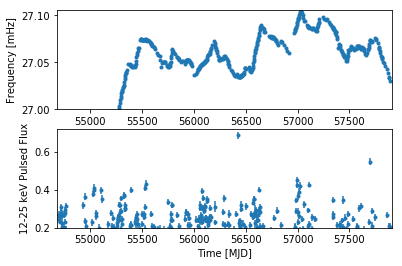

In [8]:
oao1657.plot(amin = .2, fmin = 27.)

## The 'X' range can be independently set by changing the Pulsar.tmin or Pulsar.tmax or using the keyword tmin and tmax in the Pulsar.plot() call. The 'Y' range can only be independently changed with keywords in the Pulsar.plot() call.

In [9]:
print(oao1657.fmin)

27.0


In [10]:
print(oao1657.tmin)

54675.5782748


In [11]:
print(oao1657.fmin)

27.0


In [12]:
oao1657.tmin = 55500

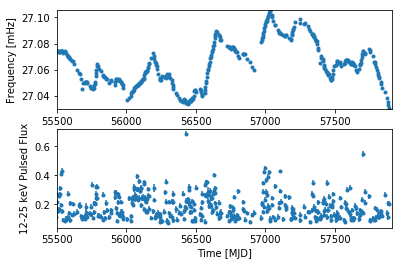

In [13]:
oao1657.plot()